In [1]:
import re
import openpyxl
import os

def convert_java_to_uml(java_code):
    # Regular expression patterns to extract method calls and conditions
    method_call_pattern = re.compile(r"\b([a-zA-Z_]\w*)\s*\.\s*([a-zA-Z_]\w*)\s*\((.*?)\)")
    if_else_pattern = re.compile(r"(if\s*\(.?\))\s({[^}]})(?:\s*else\s({[^}]*}))?")
    while_pattern = re.compile(r"while\s*\((.*?)\)")

    uml_syntax = "participantspacing equal\n"

    # Detect participants (actors and entities)
    participants = {"Game", "Player", "Dice", "Board", "Queue", "System"}
    used_participants = set()  # Keep track of used participants
    for participant in participants:
        uml_syntax += f"participant {participant}\n"

    uml_syntax += "\nactivate Game\n"

    lines = java_code.split('\n')
    indentation = 0
    for line in lines:
        line = line.strip()

        # Check for method calls
        method_calls = method_call_pattern.findall(line)
        for method_call in method_calls:
            calling_participant, called_method, arguments = method_call
            uml_syntax += f"{'  ' * indentation}{calling_participant}->{called_method}: {arguments}\n"
            used_participants.add(calling_participant)

        # Check for if-else blocks
        if_else_matches = if_else_pattern.findall(line)
        for if_else_match in if_else_matches:
            if_condition, if_body, else_body = if_else_match
            uml_syntax += f"{'  ' * indentation}alt {if_condition}\n"
            indentation += 1
            if if_body:
                uml_syntax += '  ' * indentation + '\n'.join(if_body.splitlines()) + '\n'
            if else_body:
                uml_syntax += f"{'  ' * indentation}else\n"
                uml_syntax += '  ' * indentation + '\n'.join(else_body.splitlines()) + '\n'
            indentation -= 1
            uml_syntax += f"{'  ' * indentation}end\n"

        # Check for while loops
        while_condition_matches = while_pattern.findall(line)
        for while_condition in while_condition_matches:
            uml_syntax += f"{'  ' * indentation}loop {while_condition}\n"
            indentation += 1

        # Detect end of condition or loop
        if "}" in line:
            indentation -= 1
            uml_syntax += f"{'  ' * indentation}//deactivate {line.split('}')[0].strip()}\n"

    # Remove unused participants from the final UML representation
    for participant in participants - used_participants:
        uml_syntax = uml_syntax.replace(f"participant {participant}\n", "")

    return uml_syntax

# Function to read Java methods from Excel and convert to UML
def process_java_methods_from_excel(file_path):
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook.active

    # Assuming Java methods are in column 2 (index 1 in Python)
    java_methods = [cell.value for cell in sheet['B'][1:] if cell.value]

    # Create the 'UMLTextSyntax' folder if it doesn't exist
    output_folder = "UMLTextSyntax"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, method in enumerate(java_methods):
        # Convert each method to UML representation
        uml_text = convert_java_to_uml(method)

        # Save the UML representation to a file using UTF-8 encoding
        output_file = os.path.join(output_folder, f"{i + 1}.txt")
        with open(output_file, "w", encoding="utf-8") as f:
            f.write(uml_text)

# Example usage
file_path = 'Dataset.xlsx'
process_java_methods_from_excel(file_path)

In [2]:
import os
import time
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import pyautogui

# Chrome options to set the initial zoom level
chrome_options = Options()
chrome_options.add_argument("--start-maximized")
chrome_options.add_argument("--disable-extensions")
chrome_options.add_argument("--disable-infobars")
chrome_options.add_argument("--disable-notifications")
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--window-size=1366x768")
chrome_options.add_argument("--force-device-scale-factor=0.6")

# Initialize the Chrome webdriver with the specified options
driver = webdriver.Chrome(options=chrome_options)

# Open the website
driver.get('https://sequencediagram.org/')

# Wait for the page to load
time.sleep(1)

# Function to handle input, generate diagram, and save image
def process_text_and_save_image(text, filename, output_directory):
    # Find the CodeMirror text area on the website
    input_field = WebDriverWait(driver, 1).until(
        EC.presence_of_element_located((By.CLASS_NAME, 'CodeMirror')))

    # Execute a script to set the value of the text area
    driver.execute_script("arguments[0].CodeMirror.setValue(arguments[1]);", input_field, text)

    # Take a screenshot before clicking the "Generate Diagram" button
    take_screenshot(screenshot_number, output_directory)

    # Click the "Generate Diagram" button
    try:
        generate_button = WebDriverWait(driver, 1).until(
            EC.element_to_be_clickable((By.ID, 'generate')))
        generate_button.click()
    except TimeoutException:
        print("Timeout while waiting for 'Generate Diagram' button to be clickable.")
        return

    # Wait for the diagram to be generated
    time.sleep(2)

    # Find the "Export" button
    export_button = WebDriverWait(driver, 1).until(
        EC.presence_of_element_located((By.ID, 'exportButton')))
    export_button.click()

    # Click the "Export To..." button
    export_to_button = WebDriverWait(driver, 1).until(
        EC.element_to_be_clickable((By.ID, 'exportButtonPng')))
    export_to_button.click()

    # Wait for the download link to be available
    download_button = WebDriverWait(driver, 1).until(
        EC.presence_of_element_located((By.ID, 'downloadButtonPngLink')))

    # Get the image URL from the download link
    image_url = download_button.get_attribute('href')

    # Save the image to the output directory with the same filename as the input text file
    output_filename = os.path.splitext(filename)[0] + '.png'
    output_path = os.path.join(output_directory, output_filename)
    driver.get(image_url)  # Download the image using the URL
    time.sleep(1)  # Wait for the download to complete
    os.rename('SequenceDiagram.png', output_path)  
    print(f"Saved image: {output_path}")

    # Close the export menu by clicking outside it
    driver.find_element_by_xpath('//body').click()

# Function to take a screenshot and save it with the given screenshot number and output directory
def take_screenshot(screenshot_number, output_directory):
    # Pause for a moment to ensure Chrome has enough time to open
    time.sleep(1)

    # Take a screenshot and save it with the given screenshot number
    screenshot_filename = f"{screenshot_number}.png"
    screenshot_path = os.path.join(output_directory, screenshot_filename)
    screenshot = pyautogui.screenshot()
    screenshot.save(screenshot_path)
    print(f"Screenshot saved as '{screenshot_filename}'")

# Directory containing input text files
input_directory = 'UMLTextSyntax'
# Directory to save output PNG images
output_directory = 'DiagramsOutputs'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Initialize the screenshot number
screenshot_number = 1

# Iterate through the text files and insert them into the website
for filename in os.listdir(input_directory):
    if filename.endswith('.txt'):
        with open(os.path.join(input_directory, filename), 'r') as file:
            text = file.read()

        # Call the function to process and save the image with the current screenshot number
        process_text_and_save_image(text, filename, output_directory)

        # Increment the screenshot number for the next iteration
        screenshot_number += 1

        # Find the input field again for the next iteration
        driver.get('https://sequencediagram.org/')
        time.sleep(1)

# Close the browser
driver.quit()

Screenshot saved as '1.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '2.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '3.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '4.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '5.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '6.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '7.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '8.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '9.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '10.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '11.png'


Screenshot saved as '85.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '86.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '87.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '88.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '89.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '90.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '91.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '92.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '93.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as '94.png'
Timeout while waiting for 'Generate Diagram' button to be clickable.
Screenshot saved as 

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to process a single image
def process_image(image_path):
    # Read the image from the given path
    image = cv2.imread(image_path)

    # Calculate the height and width of the image in pixels
    height, width, _ = image.shape

    # Calculate the number of pixels
    top_crop_pixels = int(2 * height / 28.346)
    bottom_crop_pixels = int(4 * height / 28.346)

    # Crop the image to remove the specified regions
    cropped_image = image[top_crop_pixels:-bottom_crop_pixels, :]

    # Calculate the number of pixels
    left_crop_pixels = int(4.5 * width / 28.346)

    # Crop the image
    cropped_image = cropped_image[:, left_crop_pixels:]

    # Convert the cropped image to grayscale
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to remove light gray regions
    _, thresholded = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY)

    # Continue with the rest of your image processing pipeline
    blur = cv2.GaussianBlur(thresholded, (11, 11), 0)
    canny = cv2.Canny(blur, 30, 150, 3)
    dilated = cv2.dilate(canny, (1, 1), iterations=1)

    (cnt, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    return len(cnt)

# Folder path containing the images
folder_path = 'DiagramsOutputs/'

# Get a list of all image files in the folder
image_files = [f"{i}.png" for i in range(1, 101)]

# Initialize an array to store the object counts
object_counts = []

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    cnt = process_image(image_path)

    object_counts.append(cnt)

    print(f"Number of objects in the Sequence Diagram {image_file}: {cnt}")

# Print the array of object counts
print("Object counts by order:", object_counts)


Number of objects in the Sequence Diagram 1.png: 308
Number of objects in the Sequence Diagram 2.png: 343
Number of objects in the Sequence Diagram 3.png: 93
Number of objects in the Sequence Diagram 4.png: 161
Number of objects in the Sequence Diagram 5.png: 425
Number of objects in the Sequence Diagram 6.png: 315
Number of objects in the Sequence Diagram 7.png: 608
Number of objects in the Sequence Diagram 8.png: 70
Number of objects in the Sequence Diagram 9.png: 203
Number of objects in the Sequence Diagram 10.png: 404
Number of objects in the Sequence Diagram 11.png: 190
Number of objects in the Sequence Diagram 12.png: 88
Number of objects in the Sequence Diagram 13.png: 89
Number of objects in the Sequence Diagram 14.png: 59
Number of objects in the Sequence Diagram 15.png: 263
Number of objects in the Sequence Diagram 16.png: 516
Number of objects in the Sequence Diagram 17.png: 47
Number of objects in the Sequence Diagram 18.png: 124
Number of objects in the Sequence Diagram 1

In [4]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd

# Read the Excel file
df = pd.read_excel('Dataset.xlsx')
urls = df['URL'].tolist()

# Initialize the Chrome webdriver
driver = webdriver.Chrome()

# Open the website
driver.get('https://gitcompare.com/')

# Wait for the page to load
wait = WebDriverWait(driver, 10)
input_field = wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, 'div.jss45 input[type="search"]')))

def extract_project_info(url):
    # Locate the table row containing the data using XPath and the href attribute of the <a> tag
    table_row = driver.find_element(By.XPATH, f"//tbody//a[@href='{url}']/ancestor::tr")
    
    # Extract cells within the table row
    cells = table_row.find_elements(By.TAG_NAME, "td")
    
    # Extract stars, watchers, and forks values from the cells
    stars = cells[3].text
    watchers = cells[4].text
    forks = cells[5].text

    return stars, watchers, forks

# Iterate through the URLs and insert them into the website
for url in urls:
    try:
        # Clear the input field
        input_field.clear()

        # Enter the URL into the input field
        input_field.send_keys(url)

        # Submit the form by pressing the Enter key
        input_field.send_keys(Keys.ENTER)

        # Wait for a new row to appear in the table
        wait.until(EC.presence_of_element_located((By.XPATH, f"//tbody//a[@href='{url}']/ancestor::tr")))

        # Extract project info
        stars, watchers, forks = extract_project_info(url)
        print("URL:", url)
        print("Stars:", stars)
        print("Watchers:", watchers)
        print("Forks:", forks)
        print("---")

        # Update the DataFrame with project info
        df.loc[df['URL'] == url, 'stars'] = stars
        df.loc[df['URL'] == url, 'watchers'] = watchers
        df.loc[df['URL'] == url, 'forks'] = forks

        # Save the updated DataFrame back to the Excel file
        df.to_excel('Dataset.xlsx', index=False)
        
    except Exception as e:
        print(f"An error occurred for URL: {url}")
        print(str(e))

# Close the browser
driver.quit()

URL: https://github.com/gopalbala/snake-and-ladder
Stars: 16
Watchers: 2
Forks: 19
---
URL: https://github.com/caizhangbin/LadderAndSnakeGame
Stars: 0
Watchers: 1
Forks: 0
---
URL: https://github.com/skumailraza/Snakes_and_Ladders
Stars: 6
Watchers: 1
Forks: 19
---
URL: https://github.com/sunny-shaw/SnakeAndLadder
Stars: 1
Watchers: 1
Forks: 10
---
URL: https://github.com/inaseem/SnakeAndLadderFX
Stars: 8
Watchers: 0
Forks: 4
---
URL: https://github.com/scaleracademy/SnakeAndLadder
Stars: 2
Watchers: 2
Forks: 7
---
URL: https://github.com/sejaltamboli/Snake-And-Ladder-Game-Simulator-repo
Stars: 0
Watchers: 1
Forks: 0
---
URL: https://github.com/hitanshu310/SnakeAndLadderLLD
Stars: 1
Watchers: 2
Forks: 4
---
URL: https://github.com/Tressos-Aristomenis/Snakes-And-Ladders-JavaFX-from-scratch
Stars: 9
Watchers: 1
Forks: 2
---
URL: https://github.com/ShubhamThakur139/SnakeAndLadderDesign
Stars: 3
Watchers: 1
Forks: 2
---
URL: https://github.com/JirayuL/SnakeAndLadder
Stars: 2
Watchers: 1
Fo

URL: https://github.com/jakubdudrak/SnakesAndLadders
Stars: 0
Watchers: 1
Forks: 0
---
URL: https://github.com/TahirMansuri/TQ-PC-PP01-Snake-and-Ladder-Problem
Stars: 0
Watchers: 1
Forks: 0
---
URL: https://github.com/eyal247/SnakesAndLaddersWebApp
Stars: 0
Watchers: 3
Forks: 0
---
URL: https://github.com/fullstar5/Snakes-And-Ladders-Game
Stars: 1
Watchers: 1
Forks: 0
---
URL: https://github.com/Prasanth-1402/Snake-and-Ladder-Simulation
Stars: 0
Watchers: 1
Forks: 0
---
URL: https://github.com/SaraswathiAsuthkar/Snakes-and-Ladders2
Stars: 0
Watchers: 2
Forks: 0
---
URL: https://github.com/beni2412/snakeAndLadder
Stars: 0
Watchers: 1
Forks: 0
---


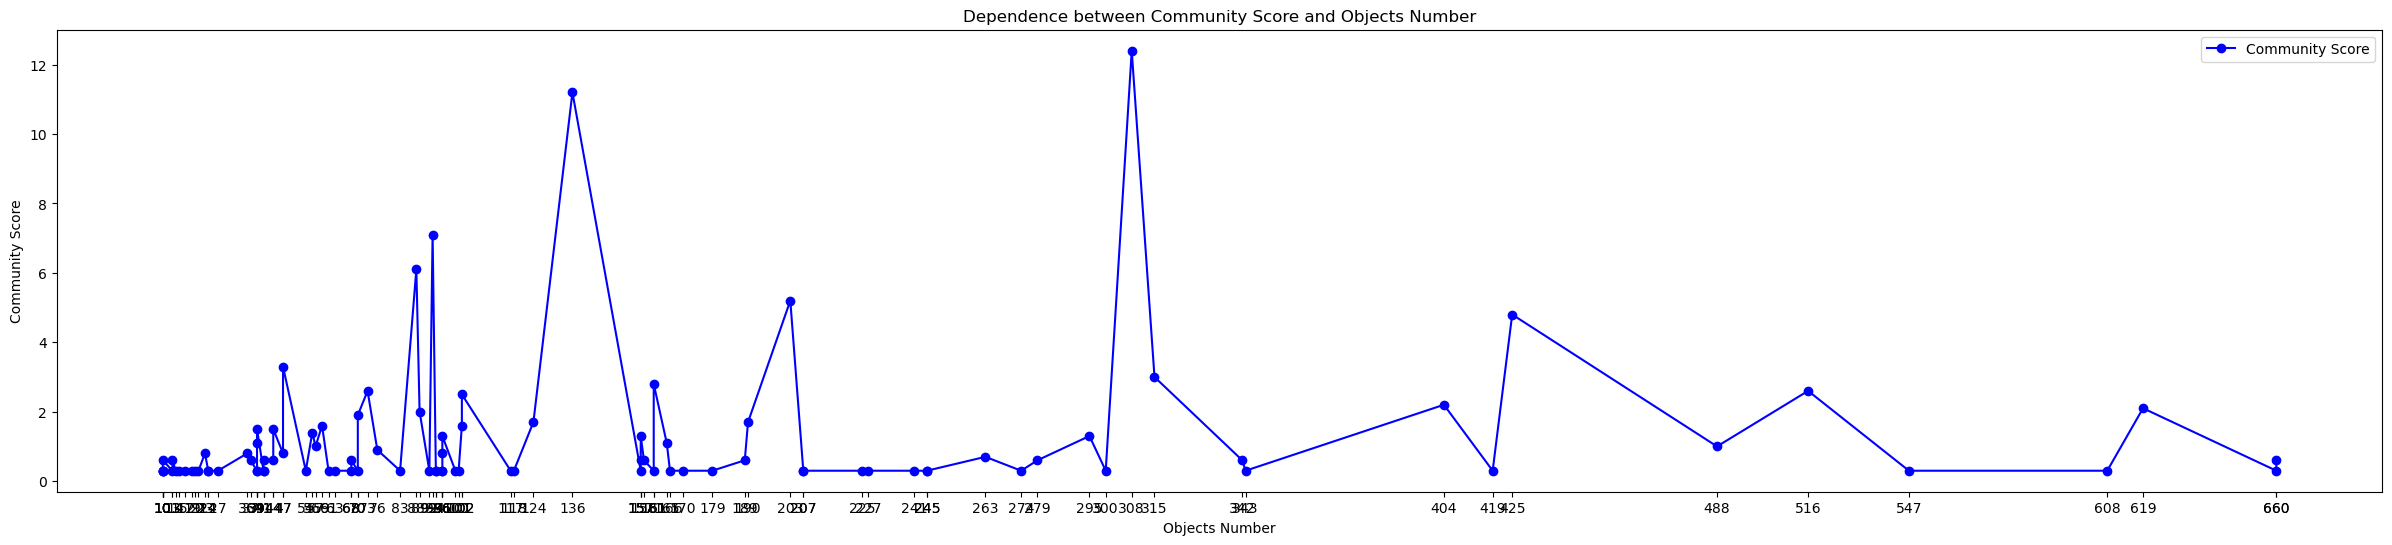

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace this with the path to your Excel file)
file_path = 'Dataset.xlsx'

# Existing community_score data
community_score = []

# Weights for the community_score calculation
StarsWeight = 0.5
WatchersWeight = 0.3
ForksWeight = 0.2

# Read data from Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Calculate the community_score for each project and add it to the existing community_score array
for index, row in df.iterrows():
    stars = row['stars']
    watchers = row['watchers']
    forks = row['forks']
    project_community_score = (stars * StarsWeight) + (watchers * WatchersWeight) + (forks * ForksWeight)
    community_score.append(project_community_score)

# Sort the data based on object_counts while preserving the original order
sorted_data = sorted(zip(object_counts, community_score))
objects_number_sorted, community_score_sorted = zip(*sorted_data)

# Set a larger figure size to make the graph wider
plt.figure(figsize=(30, 6))

# Create the line graph using sorted data, but set the ticks on the x-axis with the original object_counts list
plt.plot(objects_number_sorted, community_score_sorted, marker='o', linestyle='-', color='b', label='Community Score')
plt.xticks(object_counts, object_counts)  # Set the x-axis ticks using the original object_counts list
plt.ylabel('Community Score')
plt.xlabel('Objects Number')
plt.title('Dependence between Community Score and Objects Number')
plt.legend()

# Save the plot as an image
plt.savefig('community_score_graph.png')

# Show the plot
plt.show()